# Introduction

In this assignment you will practice putting together an image classification pipeline based on CNNs for [CIFAR-10 and/or CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The goals of this assignment are as follows:



*   Understand the components of a CNN model.
*   Understand how to modify a standard CNN model towards a specific task.
*   Implement and train a LeNet-5 model.
*   Implement and train a VGGNet model.
*   Implement and train a ResNet model.
*   Understand the differences and tradeoffs between these models.

Please fill in all the **TODO** code blocks. Once you are ready to submit:

* Export the notebook `CSCI677_assignment_3.ipynb` as a PDF `[Your USC ID]_CSCI677_assignment_3.pdf`
* Submit your PDF file through [Blackboard](https://blackboard.usc.edu/)

Please make sure that the notebook have been run before exporting PDF, and your code and all cell outputs are visible in your submitted PDF. Regrading request will not be accepted if your code/output is not visible in the original submission. Thank you!

In case you haven't installed PyTorch yet, run the following command to install torch and torchvision.

In [ ]:
!pip install torch torchvision

# **Data Preparation**

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a well known dataset composed of 60,000 colored 32x32 images in 10 classes, with 6000 images per class. The utility function `cifar10()` returns the entire CIFAR-10 dataset as a set of four Torch tensors:
* `x_train` contains all training images (real numbers in the range  [0,1] )
* `y_train` contains all training labels (integers in the range  [0,9] )
* `x_test` contains all test images
* `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

[CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) is just like the CIFAR-10 dataset, except it has 100 classes containing 600 images each. Below we provided wrapper classes for CIFAR-10 and CIFAR-100 datasets. You can choose one or both of them for training your CNNs. If you choose one of them, use the same one to train all your models.

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

class CIFAR10Dataset:
    def __init__(self, batch_size=128, root="data"):
        self.transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]
        )
        self.batch_size = batch_size

        self.training_data = datasets.CIFAR10(
            root=root,
            train=True,
            download=True,
            transform=self.transform
        )
        self.train_dataloader = DataLoader(self.training_data, batch_size=self.batch_size, shuffle=True)

        self.test_data = datasets.CIFAR10(
            root=root,
            train=False,
            download=False,
            transform=self.transform
        )
        self.test_dataloader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class CIFAR100Dataset:
    def __init__(self, batch_size=128, root="data"):
        self.transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))]  # CIFAR-100 normalization values
        )
        self.batch_size = batch_size

        self.training_data = datasets.CIFAR100(
            root=root,
            train=True,
            download=True,
            transform=self.transform
        )
        self.train_dataloader = DataLoader(self.training_data, batch_size=self.batch_size, shuffle=True)

        self.test_data = datasets.CIFAR100(
            root=root,
            train=False,
            download=False,
            transform=self.transform
        )
        self.test_dataloader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

        self.classes = self.training_data.classes


/home/jingmin/anaconda3/envs/adapter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LeNet-5 (20 pts)
LeNet-5, introduced by Yann LeCun in 1998, is a relatively shallow network. It consists of two convolutional layers and two fully connected layers. LeNet-5 was designed for handwritten digit recognition tasks and had a relatively small number of parameters.

## Implement LeNet-5 (10 pts)
Classical LeNet-5 architecture is as follows:


![LeNet-5 Architecture](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png)


Its input is 32x32x1 because it was designed for greyscale images of 32x32. However, inputs from CIFAR-10/100 are colored 32x32 images, therefore you need to modify it. Requirements:
* The model should take inputs of 32x32x3 and output a vector of dimension equal to the number of classes (10 for CIFAR-10 and 100 for CIFAR-100).
* The model should have 2 convolutional layers and 3 fully connected layers::

  (Convolution -> Sigmoid -> Average Pooling) ->

  (Convolution -> Sigmoid -> Average Pooling) ->

  Flattening ->

  (Linear -> Sigmoid) ->

  (Linear -> Sigmoid) -> Linear.
* Use 5x5 convolutional filters.

**Hint**: you can use nn.Sequential() to simplify your implementation.

In [2]:
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # TODO
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        # TODO
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1) # faltten
        x = self.classifier(x)
        return x


## Visualization (10 pts)
Visualize your LeNet-5 using Tensorboard or Netron. Make sure each component of your model is visible.

In [7]:
# TODO
import torch.onnx

def export_to_onnx(model, filename, input_shape):
    model.eval()
    x = torch.randn(input_shape)
    torch.onnx.export(model, x, filename, export_params=True, opset_version=10, 
                  do_constant_folding=True, input_names = ['input'], output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}})

lenet = LeNet5(num_classes=10)
export_to_onnx(lenet, "lenet5.onnx", (1, 3, 32, 32))

In [ ]:
!netron lenet5.onnx

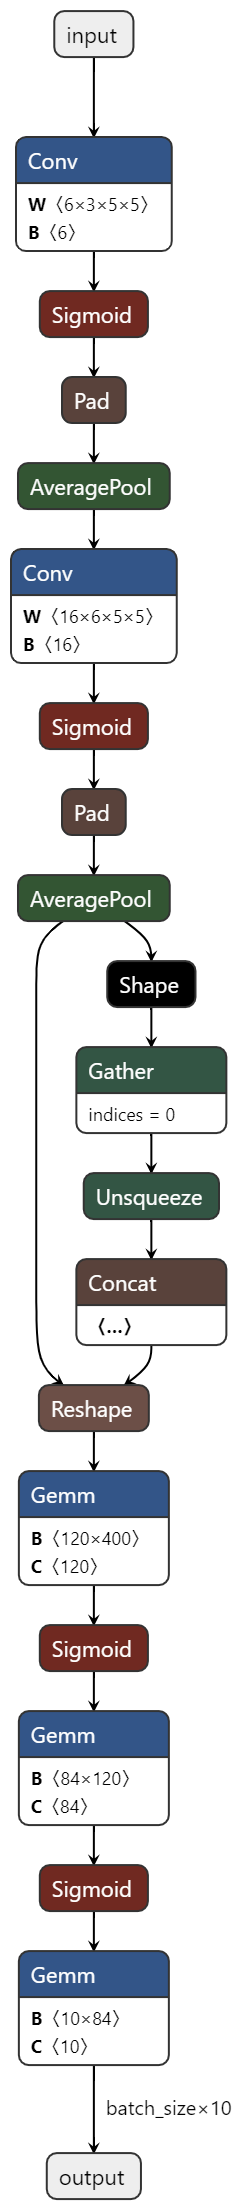

# VGGNet (20 pts)
VGGNet, or Visual Geometry Group Network, is a deep convolutional neural network (CNN) architecture introduced in 2014, known for its simplicity and depth. It employs a uniform structure with small 3x3 convolutional kernels throughout its layers, emphasizing the advantages of increased depth in CNNs. In comparison to AlexNet, VGGNet's uniformity and architectural simplicity make it an influential reference model in deep learning, demonstrating the effectiveness of deeper networks and smaller convolutional kernels for image classification tasks.

In this section, you will implement a variant of VGGNet for CIFAR-10/100.

## Implement VGGNet (20 pts)
Classical VGGNet architecture is as follows:


![VGGNet Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*HzxRI1qHXjiVXla-_NiMBA.png)


It has 13 convolutional layers and 3 fully connected layers. Its input is 224x224x3 because it was designed for ImageNet. Again, inputs from CIFAR-10/100 are colored 32x32 images, therefore you need to modify it. Requirements:
* The model should take inputs of 32x32x3 and output a vector of dimension equal to the number of classes (10 for CIFAR-10 and 100 for CIFAR-100).
* The model should have 10 convolutional layers and 3 fully connected layers:

 (Conv -> ReLU -> Conv -> ReLU -> Max Pool) ->

 (Conv -> ReLU -> Conv -> ReLU -> Max Pool) ->

 (Conv -> ReLU -> Conv -> ReLU -> Conv -> ReLU -> Max Pool) ->

 (Conv -> ReLU -> Conv -> ReLU -> Conv -> ReLU -> Max Pool) ->

 Flattening ->

 (Linear -> ReLU -> Dropout) ->

 (Linear -> ReLU -> Dropout) -> Linear.
* Use 3x3 convolutional filters with padding 1.

**Hint**: you can use nn.Sequential() or define make_layer() function by yourself to simplify your implementation.

In [3]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        # TODO
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        # TODO
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # faltten
        x = self.classifier(x)
        return x

In [27]:
# vggnet_cifar10 = VGGNet(num_classes=10)
# vggnet_cifar100 = VGGNet(num_classes=100)
vggnet = VGGNet(num_classes=10)
export_to_onnx(vggnet, "vggnet.onnx", (1, 3, 32, 32))

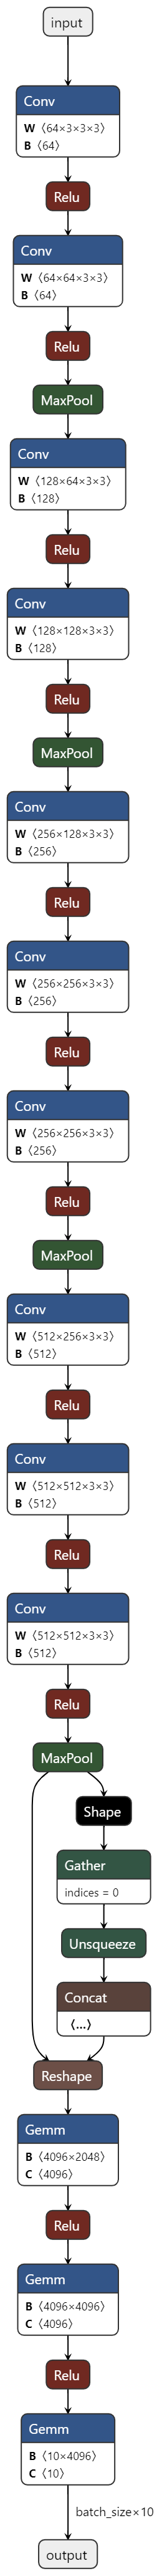

# ResNet (20 pts)
ResNet, short for Residual Network, was introduced in 2015 by Kaiming He et al. At its core, ResNet introduces the concept of residual blocks, which allows gradients to flow directly through the network's many layers. In comparison to earlier architectures like AlexNet, ResNet's approach demonstrates the transformative power of residual connections.

In this section, you will implement ResNet-18 for CIFAR-10/100.

## Implement Residual Block (10 pts)
The Residual Block is a crucial component in ResNet. It works by introducing a shortcut connection, also known as a skip connection, alongside a regular neural network layer. This shortcut connection enables the flow of information directly from one layer to another, bypassing some intermediate layers.

The key idea is to learn a residual function, which represents the difference between the desired output and the current output of the block. By doing so, the block aims to make the output closer to what it should be. This approach mitigates the vanishing gradient problem, which can occur in very deep networks, making it easier to train deep models effectively.

![Residual Block](https://miro.medium.com/v2/resize:fit:1140/format:webp/1*6WlIo8W1_Qc01hjWdZy-1Q.png)


The weight layer usually consists of a convolutional layer and a batch normalization layer. The batch normalization layer, often abbreviated as BatchNorm, normalizes the input of a neural network layer across a mini-batch of data during training. BatchNorm not only accelerates convergence but also acts as a form of regularization, reducing the risk of overfitting. In PyTorch, it is implemented by nn.BatchNorm2d().

You are asked to implement the residual block with the following requirements:
* The residual block takes input of size n * n * `in_channels` and output m * m * `out_channels` with m = (n-1) / `stride` + 1
* The residual function consists of the following components:

  Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm

  where Conv means 3x3 convolutional filters with padding 1. If `stride` != 1, set stride for the first Conv.
* The shortcut should be identity if `in_channels` == `out_channels` and `stride` == 1. Otherwise, it should be a convolutional layer with kernel_size=1 and stride=`stride`.
* After adding the residual function and the shortcut, apply another ReLU activation.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # TODO
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # TODO
        residual = self.residual_function(x)
        shortcut = self.shortcut(x) # identity mapping
        x = residual + shortcut 
        return x

## Implement ResNet-18 (10 pts)
ResNet-18 is part of the ResNet family, known for its exceptional depth and performance in image classification tasks. It consists of 18 layers, beginning with one convolutional layer, followed by a few residual blocks, and ending with a fully-connected layer. Here is a glimpse of its architecture:


![ResNet-18](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)


You are asked to implement ResNet-18 for CIFAR-10/100. Requirements:
* The model should take inputs of 32x32x3 and output a vector of dimension equal to the number of classes (10 for CIFAR-10 and 100 for CIFAR-100).
* The model should begin with a convolutional layer with kernel_size=3 and padding=1:

  Conv -> BatchNorm -> ReLU

  The output size should be 32x32x64.
* After the first layer, append with 8 residual blocks such that the output size changes as follows:
  
  32x32x64 -> 32x32x64 -> 32x32x64 -> 16x16x128 -> 16x16x128 -> 8x8x256 -> 8x8x256 -> 4x4x512 -> 4x4x512
* The model should end with average pooling (kernel_size=4), flattening, and a fully-connected layer.


In [5]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # TODO
        # intial conv
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # residual layers
        self.layer1 = self._make_layer(ResidualBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, 2, stride=2)
        # classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        # TODO
        x = self.conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)
        return x

In [24]:
resnet18 = ResNet18(num_classes=10)
export_to_onnx(resnet18, "resnet18.onnx", (1, 3, 32, 32))

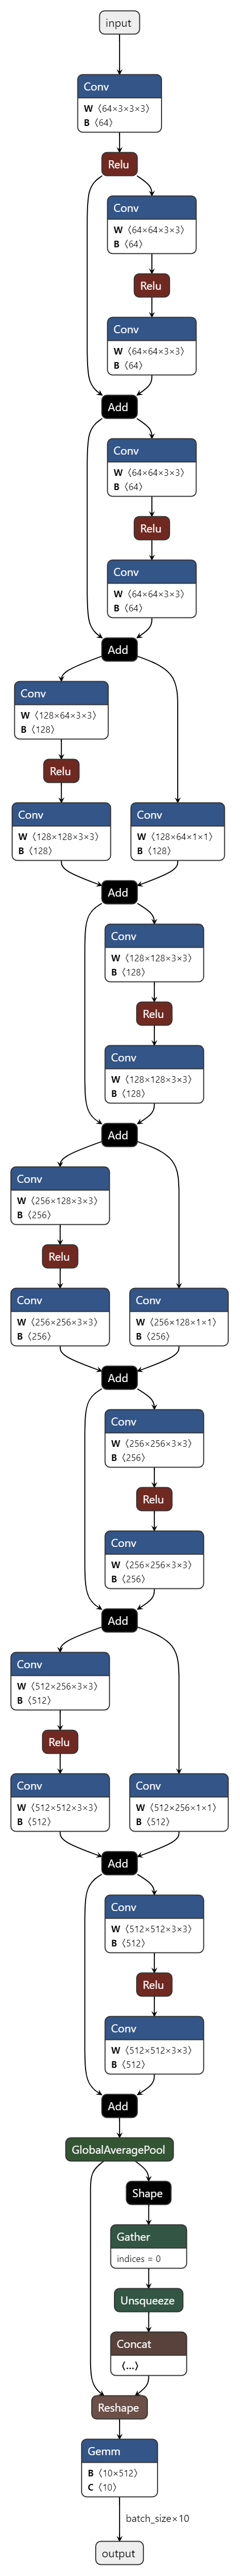

# Training Neural Networks (40 pts)
In this section, you will implement a `Trainer` class, use it to train the models that you defined previously, and evaluate them.

## Check CUDA and GPUs
The following code helps you check if CUDA is available and lists the available GPUs.

In [6]:
import torch
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of each GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

    # Set the current GPU device
    torch.cuda.set_device(1) # set to cuda:1
    device = torch.cuda.current_device()
    print(f"Current GPU device: {device} - {torch.cuda.get_device_name(device)}")
else:
    print("CUDA is not available.")

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090
Current GPU device: 1 - NVIDIA GeForce RTX 3090


## Complete the Trainer Class (15 pts)
Fill-in all the TODOs

In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm
import time


class Trainer:
    def __init__(self, dataset, net, optimizer, loss_function=nn.CrossEntropyLoss(),
                 device="cuda:1" if torch.cuda.is_available() else "cpu"):
        self.dataset = dataset
        self.net = net.to(device)
        self.lossFunction = loss_function
        self.optimizer = optimizer
        self.device = device

    def train_one_epoch(self):
        # TODO (5 pts): complete training loop
        start_time = time.time()
        self.net.train()
        train_loss = 0 
        for i, (X_train, y_train) in enumerate(tqdm(self.dataset.train_dataloader, desc="Training", leave=False)):
            X_train, y_train = X_train.to(self.device), y_train.to(self.device)
            self.optimizer.zero_grad()
            output = self.net(X_train)
            loss = self.lossFunction(output, y_train)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
        avg_loss = train_loss / len(self.dataset.train_dataloader)
        end_time = time.time()
        training_time = end_time - start_time
        # print('Average train loss in this epoch: {:.4f}'.format(avg_loss))
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(self.device)
            print('GPU mem: {:.2f} MB'.format(gpu_memory / (1024 * 1024)))
        return avg_loss, training_time

    def compute_test_accuracy(self):
        # TODO (5 pts): compute classification accuracy based on test data
        self.net.eval()
        corrects = 0
        total = 0
        with torch.no_grad():
            for i, (X_test, y_test) in enumerate(tqdm(self.dataset.test_dataloader, desc="Validating", leave=False)):
                X_test, y_test = X_test.to(self.device), y_test.to(self.device)
                output = self.net(X_test)
                _, y_pred = torch.max(output.data, 1)
                total += y_test.size(0)
                corrects += (y_pred == y_test).sum().item()

        test_acc = 100.0 * corrects / total
        # print('Test Accuracy: {:.2f}%'.format(test_acc))
        return test_acc

    def train(self, num_epochs=20):
        Train_loss = []
        Val_acc = []
        for epoch in range(num_epochs):
            avg_loss, training_time = self.train_one_epoch()
            # TODO (5 pts): print loss for every epoch, print test accuracy for every 5 epochs
            # Feel free to record the training process for analysis
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Training Time: {training_time:.2f}s")
            Train_loss.append(avg_loss)

            if (epoch + 1) % 5 == 0:
                # Eval
                val_accuracy = self.compute_test_accuracy()
                print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")
                Val_acc.append(val_accuracy)
        
        return Train_loss, Val_acc

## Training (5 pts)
Follow these steps:
* Create the model, the dataset, and the optimizer.
* Configure the trainer.
* Compute and print test accuracy before training.
* Train the model.
* Compute and print test accuracy after training.

In [8]:
# TODO
cifar10_dataset = CIFAR10Dataset() # dataset
resnet18_cifar10 = ResNet18(num_classes=10) # model
optimizer = torch.optim.Adam(resnet18_cifar10.parameters(), lr=0.001) # optimizer
loss_function = nn.CrossEntropyLoss().to(device) # loss function
trainer = Trainer(cifar10_dataset, resnet18_cifar10, optimizer, loss_function) # trainer

Train_loss_cifar10, Val_acc_cifar10 = trainer.train(num_epochs=30)

Files already downloaded and verified


GPU mem: 175.25 MB
Epoch 1/30, Train Loss: 1.5194, Training Time: 19.69s


GPU mem: 175.25 MB
Epoch 2/30, Train Loss: 1.0373, Training Time: 17.45s


GPU mem: 175.25 MB
Epoch 3/30, Train Loss: 0.8443, Training Time: 17.18s


GPU mem: 175.25 MB
Epoch 4/30, Train Loss: 0.7100, Training Time: 17.21s


GPU mem: 175.25 MB
Epoch 5/30, Train Loss: 0.6009, Training Time: 17.23s


Epoch 5/30, Validation Accuracy: 75.45%


GPU mem: 175.25 MB
Epoch 6/30, Train Loss: 0.5235, Training Time: 17.24s


GPU mem: 175.25 MB
Epoch 7/30, Train Loss: 0.4606, Training Time: 17.06s


GPU mem: 175.25 MB
Epoch 8/30, Train Loss: 0.4050, Training Time: 17.00s


GPU mem: 175.25 MB
Epoch 9/30, Train Loss: 0.3527, Training Time: 17.17s


GPU mem: 175.25 MB
Epoch 10/30, Train Loss: 0.3048, Training Time: 17.47s


Epoch 10/30, Validation Accuracy: 80.70%


GPU mem: 175.25 MB
Epoch 11/30, Train Loss: 0.2567, Training Time: 18.52s


GPU mem: 175.25 MB
Epoch 12/30, Train Loss: 0.2193, Training Time: 18.54s


GPU mem: 175.25 MB
Epoch 13/30, Train Loss: 0.1785, Training Time: 18.52s


GPU mem: 175.25 MB
Epoch 14/30, Train Loss: 0.1528, Training Time: 18.53s


GPU mem: 175.25 MB
Epoch 15/30, Train Loss: 0.1253, Training Time: 18.58s


Epoch 15/30, Validation Accuracy: 82.45%


GPU mem: 175.25 MB
Epoch 16/30, Train Loss: 0.1095, Training Time: 18.62s


GPU mem: 175.25 MB
Epoch 17/30, Train Loss: 0.0947, Training Time: 18.28s


GPU mem: 175.25 MB
Epoch 18/30, Train Loss: 0.0810, Training Time: 17.19s


GPU mem: 175.25 MB
Epoch 19/30, Train Loss: 0.0761, Training Time: 17.15s


GPU mem: 175.25 MB
Epoch 20/30, Train Loss: 0.0672, Training Time: 17.14s


Epoch 20/30, Validation Accuracy: 83.13%


GPU mem: 175.25 MB
Epoch 21/30, Train Loss: 0.0619, Training Time: 17.16s


GPU mem: 175.25 MB
Epoch 22/30, Train Loss: 0.0584, Training Time: 17.15s


GPU mem: 175.25 MB
Epoch 23/30, Train Loss: 0.0546, Training Time: 17.15s


GPU mem: 175.25 MB
Epoch 24/30, Train Loss: 0.0506, Training Time: 17.16s


GPU mem: 175.25 MB
Epoch 25/30, Train Loss: 0.0498, Training Time: 17.17s


Epoch 25/30, Validation Accuracy: 83.41%


GPU mem: 175.25 MB
Epoch 26/30, Train Loss: 0.0463, Training Time: 17.20s


GPU mem: 175.25 MB
Epoch 27/30, Train Loss: 0.0434, Training Time: 17.24s


GPU mem: 175.25 MB
Epoch 28/30, Train Loss: 0.0415, Training Time: 17.21s


GPU mem: 175.25 MB
Epoch 29/30, Train Loss: 0.0377, Training Time: 17.19s


GPU mem: 175.25 MB
Epoch 30/30, Train Loss: 0.0377, Training Time: 17.21s


Epoch 30/30, Validation Accuracy: 83.21%


In [10]:
# TODO
cifar100_dataset = CIFAR100Dataset() # dataset
resnet18_cifar100 = ResNet18(num_classes=100) # model
optimizer = torch.optim.Adam(resnet18_cifar100.parameters(), lr=0.001) # optimizer
loss_function = nn.CrossEntropyLoss().to(device) # loss function
trainer = Trainer(cifar100_dataset, resnet18_cifar100, optimizer, loss_function) # trainer

Train_loss_cifar100, Val_acc_cifar100 = trainer.train(num_epochs=50)

Files already downloaded and verified


GPU mem: 439.23 MB
Epoch 1/50, Train Loss: 3.7176, Training Time: 17.27s


GPU mem: 439.23 MB
Epoch 2/50, Train Loss: 2.8697, Training Time: 17.24s


GPU mem: 439.23 MB
Epoch 3/50, Train Loss: 2.3679, Training Time: 17.26s


GPU mem: 439.23 MB
Epoch 4/50, Train Loss: 2.0531, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 5/50, Train Loss: 1.8165, Training Time: 17.22s


Epoch 5/50, Validation Accuracy: 46.12%


GPU mem: 439.23 MB
Epoch 6/50, Train Loss: 1.6049, Training Time: 17.24s


GPU mem: 439.23 MB
Epoch 7/50, Train Loss: 1.4104, Training Time: 17.24s


GPU mem: 439.23 MB
Epoch 8/50, Train Loss: 1.2246, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 9/50, Train Loss: 1.0410, Training Time: 17.22s


GPU mem: 439.23 MB
Epoch 10/50, Train Loss: 0.8477, Training Time: 17.27s


Epoch 10/50, Validation Accuracy: 53.59%


GPU mem: 439.23 MB
Epoch 11/50, Train Loss: 0.6643, Training Time: 17.26s


GPU mem: 439.23 MB
Epoch 12/50, Train Loss: 0.5026, Training Time: 17.42s


GPU mem: 439.23 MB
Epoch 13/50, Train Loss: 0.3733, Training Time: 18.76s


GPU mem: 439.23 MB
Epoch 14/50, Train Loss: 0.2840, Training Time: 18.70s


GPU mem: 439.23 MB
Epoch 15/50, Train Loss: 0.2234, Training Time: 18.68s


Epoch 15/50, Validation Accuracy: 52.47%


GPU mem: 439.23 MB
Epoch 16/50, Train Loss: 0.1939, Training Time: 18.68s


GPU mem: 439.23 MB
Epoch 17/50, Train Loss: 0.1767, Training Time: 17.71s


GPU mem: 439.23 MB
Epoch 18/50, Train Loss: 0.1551, Training Time: 17.81s


GPU mem: 439.23 MB
Epoch 19/50, Train Loss: 0.1622, Training Time: 18.67s


GPU mem: 439.23 MB
Epoch 20/50, Train Loss: 0.1258, Training Time: 18.62s


Epoch 20/50, Validation Accuracy: 52.73%


GPU mem: 439.23 MB
Epoch 21/50, Train Loss: 0.1113, Training Time: 18.58s


GPU mem: 439.23 MB
Epoch 22/50, Train Loss: 0.1299, Training Time: 17.79s


GPU mem: 439.23 MB
Epoch 23/50, Train Loss: 0.1177, Training Time: 17.22s


GPU mem: 439.23 MB
Epoch 24/50, Train Loss: 0.0987, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 25/50, Train Loss: 0.1112, Training Time: 17.23s


Epoch 25/50, Validation Accuracy: 52.29%


GPU mem: 439.23 MB
Epoch 26/50, Train Loss: 0.0866, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 27/50, Train Loss: 0.0916, Training Time: 17.09s


GPU mem: 439.23 MB
Epoch 28/50, Train Loss: 0.1031, Training Time: 17.06s


GPU mem: 439.23 MB
Epoch 29/50, Train Loss: 0.0774, Training Time: 17.16s


GPU mem: 439.23 MB
Epoch 30/50, Train Loss: 0.0641, Training Time: 17.18s


Epoch 30/50, Validation Accuracy: 53.18%


GPU mem: 439.23 MB
Epoch 31/50, Train Loss: 0.0786, Training Time: 17.17s


GPU mem: 439.23 MB
Epoch 32/50, Train Loss: 0.0790, Training Time: 17.19s


GPU mem: 439.23 MB
Epoch 33/50, Train Loss: 0.0810, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 34/50, Train Loss: 0.0698, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 35/50, Train Loss: 0.0569, Training Time: 17.27s


Epoch 35/50, Validation Accuracy: 53.42%


GPU mem: 439.23 MB
Epoch 36/50, Train Loss: 0.0840, Training Time: 17.24s


GPU mem: 439.23 MB
Epoch 37/50, Train Loss: 0.0712, Training Time: 17.28s


GPU mem: 439.23 MB
Epoch 38/50, Train Loss: 0.0608, Training Time: 17.28s


GPU mem: 439.23 MB
Epoch 39/50, Train Loss: 0.0523, Training Time: 17.24s


GPU mem: 439.23 MB
Epoch 40/50, Train Loss: 0.0643, Training Time: 17.27s


Epoch 40/50, Validation Accuracy: 52.96%


GPU mem: 439.23 MB
Epoch 41/50, Train Loss: 0.0722, Training Time: 17.16s


GPU mem: 439.23 MB
Epoch 42/50, Train Loss: 0.0523, Training Time: 17.16s


GPU mem: 439.23 MB
Epoch 43/50, Train Loss: 0.0492, Training Time: 17.14s


GPU mem: 439.23 MB
Epoch 44/50, Train Loss: 0.0488, Training Time: 17.06s


GPU mem: 439.23 MB
Epoch 45/50, Train Loss: 0.0554, Training Time: 17.20s


Epoch 45/50, Validation Accuracy: 53.48%


GPU mem: 439.23 MB
Epoch 46/50, Train Loss: 0.0521, Training Time: 17.20s


GPU mem: 439.23 MB
Epoch 47/50, Train Loss: 0.0497, Training Time: 17.20s


GPU mem: 439.23 MB
Epoch 48/50, Train Loss: 0.0480, Training Time: 17.23s


GPU mem: 439.23 MB
Epoch 49/50, Train Loss: 0.0509, Training Time: 17.25s


GPU mem: 439.23 MB
Epoch 50/50, Train Loss: 0.0542, Training Time: 17.20s


Epoch 50/50, Validation Accuracy: 53.15%


## Evaluation using Confusion Matrix (5 pts)
A confusion matrix is a fundamental tool for evaluating the performance of classification models. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.

You are asked to evaluate your trained model by computing and printing the confusion matrix. You can either compute it by yourself or use sklearn.metrics.confusion_matrix().

In [11]:
# TODO
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(dataset, net):
    net.eval()
    y_true = []
    y_preds = []
    with torch.no_grad():
        for X_test, y_test in dataset.test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            output = net(X_test)
            _, y_pred_batch = torch.max(output.data, 1)
            y_true.extend(y_test.cpu().numpy().tolist())
            y_preds.extend(y_pred_batch.cpu().numpy().tolist())
    
    test_acc = 100.0 * sum([1 if y_true[i] == y_preds[i] else 0 for i in range(len(y_true))]) / len(y_true)
    conf_matrix = confusion_matrix(y_true, y_preds)
    return conf_matrix, test_acc

conf_matrix_10, test_acc_10 = compute_confusion_matrix(cifar10_dataset, resnet18_cifar10)
print(f"Test Accuracy for cifar-10 ResNet-18: {test_acc_10:.2f}%")
print("Confusion Matrix:\n", conf_matrix_10)

conf_matrix_100, test_acc_100 = compute_confusion_matrix(cifar100_dataset, resnet18_cifar100)
print(f"\nTest Accuracy for cifar-100 ResNet-18: {test_acc_100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_100)

Test Accuracy for cifar-10 ResNet-18: 83.21%
Confusion Matrix:
 [[911   8   6   5   2   1   2   4  51  10]
 [  9 930   6   1   0   1   4   0  20  29]
 [ 96   1 766  28  18  27  39  16   7   2]
 [ 54   6  51 617  23 154  44  17  20  14]
 [ 49   3  68  48 729  25  34  31  10   3]
 [ 31   6  44  63  17 792  13  25   4   5]
 [ 26   3  26  43   5  18 868   2   7   2]
 [ 20   4  17  22  16  30   7 867   5  12]
 [ 29   7   3   1   1   0   4   0 946   9]
 [ 13  47   2   5   0   0   1   4  33 895]]

Test Accuracy for cifar-100 ResNet-18: 53.15%
Confusion Matrix:
 [[74  0  0 ...  0  0  0]
 [ 0 60  0 ...  0  0  0]
 [ 0  2 29 ...  0  5  0]
 ...
 [ 0  0  0 ... 56  1  0]
 [ 0  0  6 ...  0 28  0]
 [ 0  1  0 ...  0  0 44]]


## Observations (15 pts)
Write down your observations regarding the results you obtained throughout this assignment. Here are some suggestions:
* **Accuracy and Loss Curves**: Plot and compare the training and validation accuracy and loss curves for each model. This helps visualize how well each model is learning over time and whether they are overfitting or underfitting.
* **Top Misclassified Images**: Examine the classes that are most frequently misclassified by each model. This can provide insights into the types of images that are challenging for each model and may suggest areas for improvement.
* **Feature Visualization**: Visualize the feature maps or activations of intermediate layers in each CNN. This can help you understand what features or patterns each model is learning and whether they differ in terms of learned representations.
* **Robustness Testing**: Assess the robustness of each model by introducing noise, transformations, or adversarial examples to the test data. This can help identify which models are more resilient to perturbations.
* **Runtime and Resource Usage**: Compare the training time and resource usage (e.g., GPU memory) of each model.
* **Hyperparameter Tuning**: Analyze the impact of hyperparameters (learning rates, batch sizes, etc.) on training speed and convergence.
* **Model Size and Efficiency**: Analyze the trade-off between model size and accuracy for each model.
* **Ablation Studies**: Conduct ablation studies by removing or modifying specific components (e.g., dropout, batch normalization, etc.) of each model to understand their contributions to performance.

You don't need to follow them. Feel free to write down any observation you have, or to use tools like Tensorboard to support your observations. You are also welcome to give comments on the design of the assignment.

## **TODO: write down your observations**

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

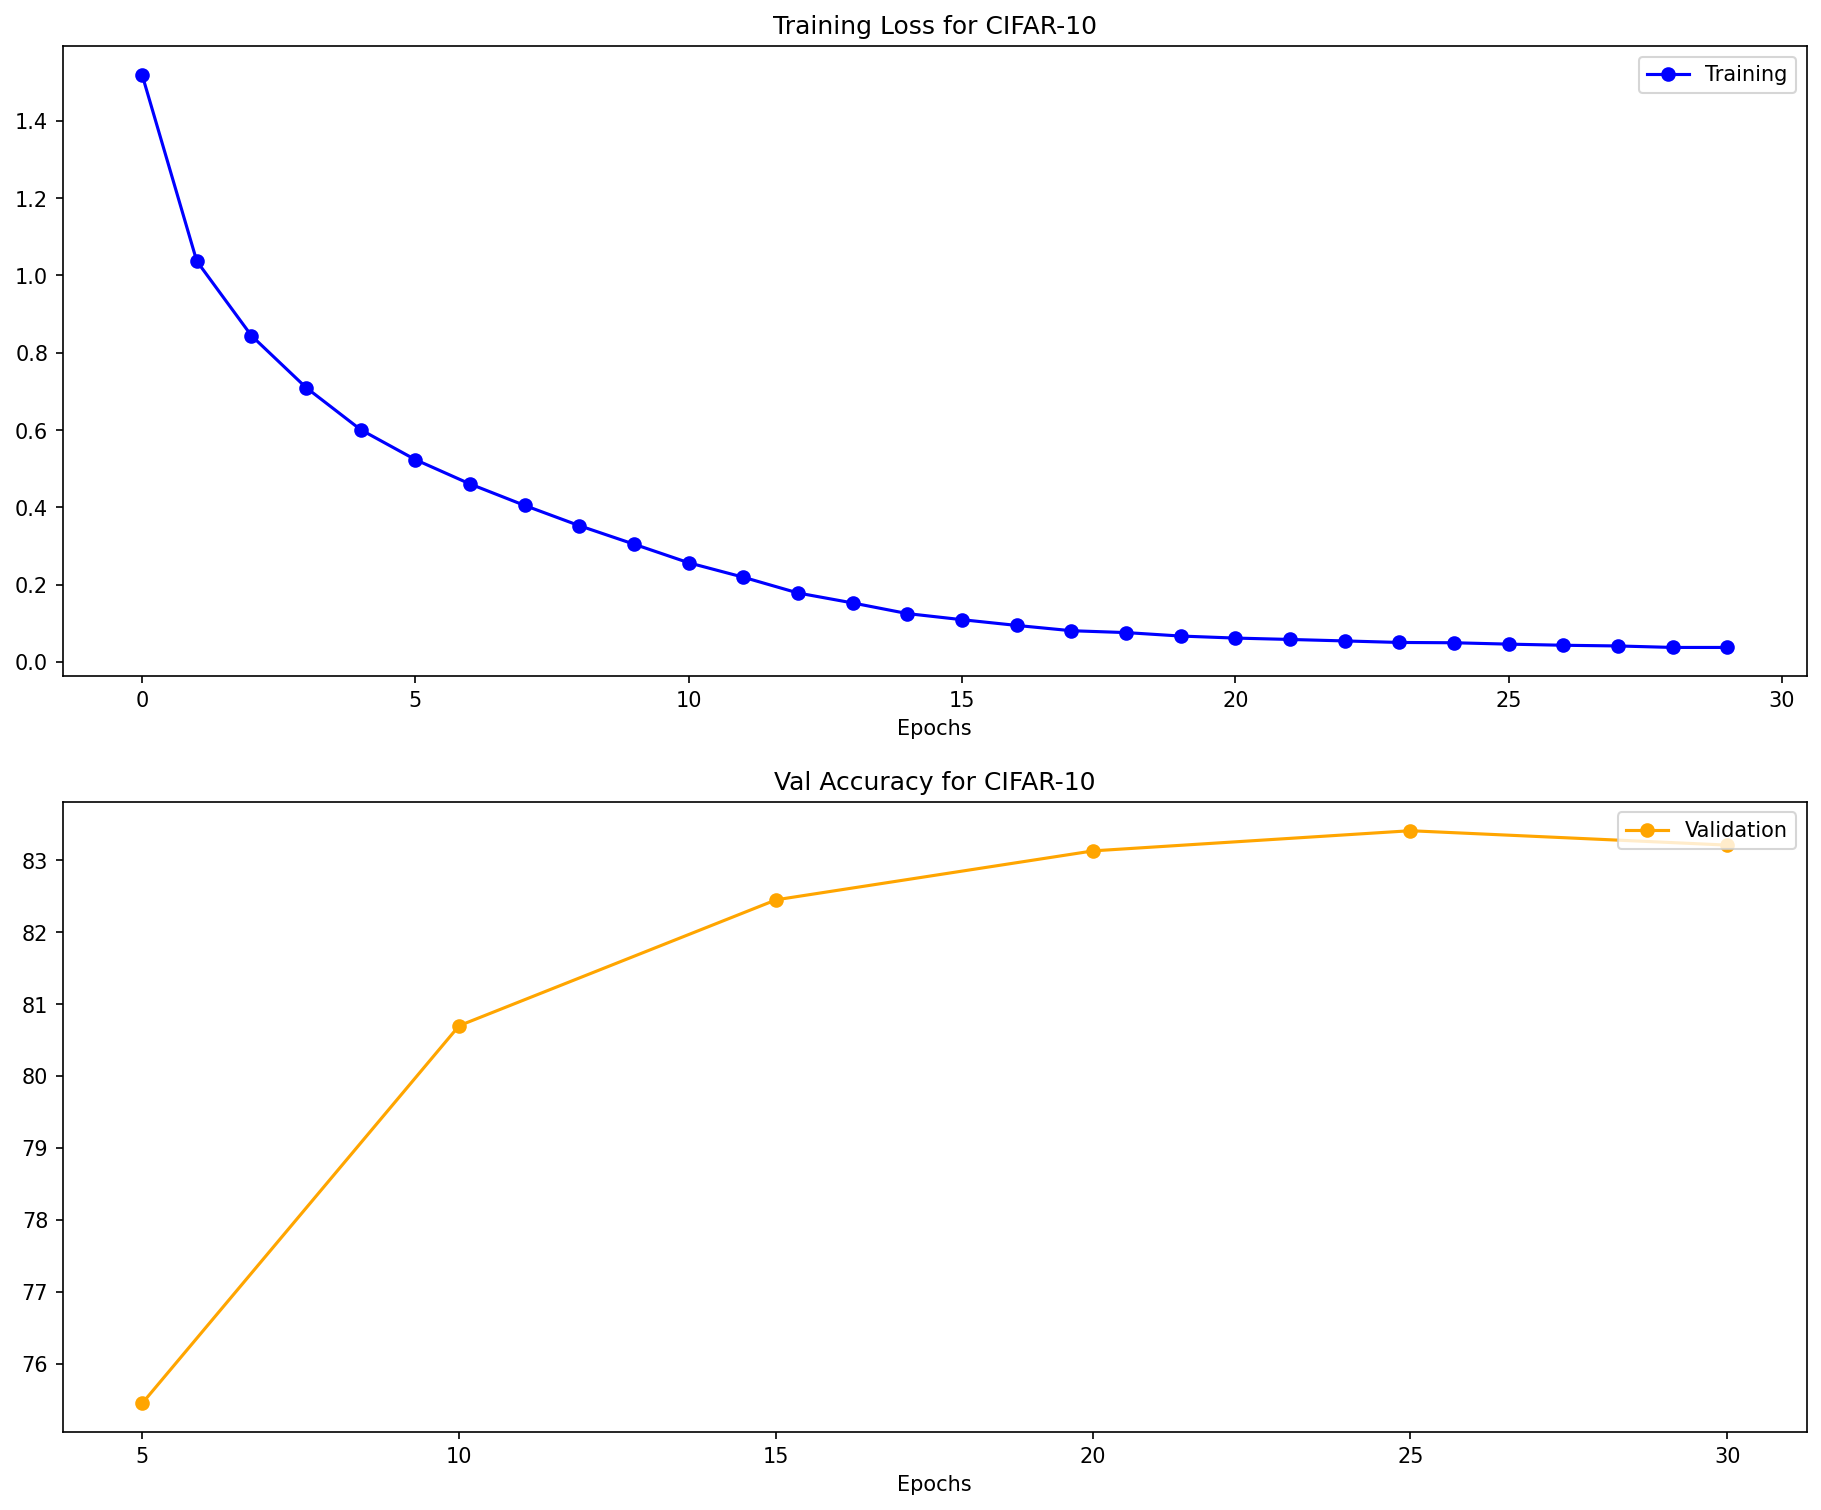

In [13]:
# draw train loss / val acc curve
plt.figure(figsize=(15, 12), dpi=150)
plt.subplot(2, 1, 1)
plt.title('Training Loss for CIFAR-10')
plt.plot(Train_loss_cifar10, '-o', label='Training', color='blue')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
epochs = [5, 10, 15, 20, 25, 30]
plt.title('Val Accuracy for CIFAR-10')
plt.plot(epochs, Val_acc_cifar10, '-o', label='Validation', color='orange')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(15, 12)

plt.show()

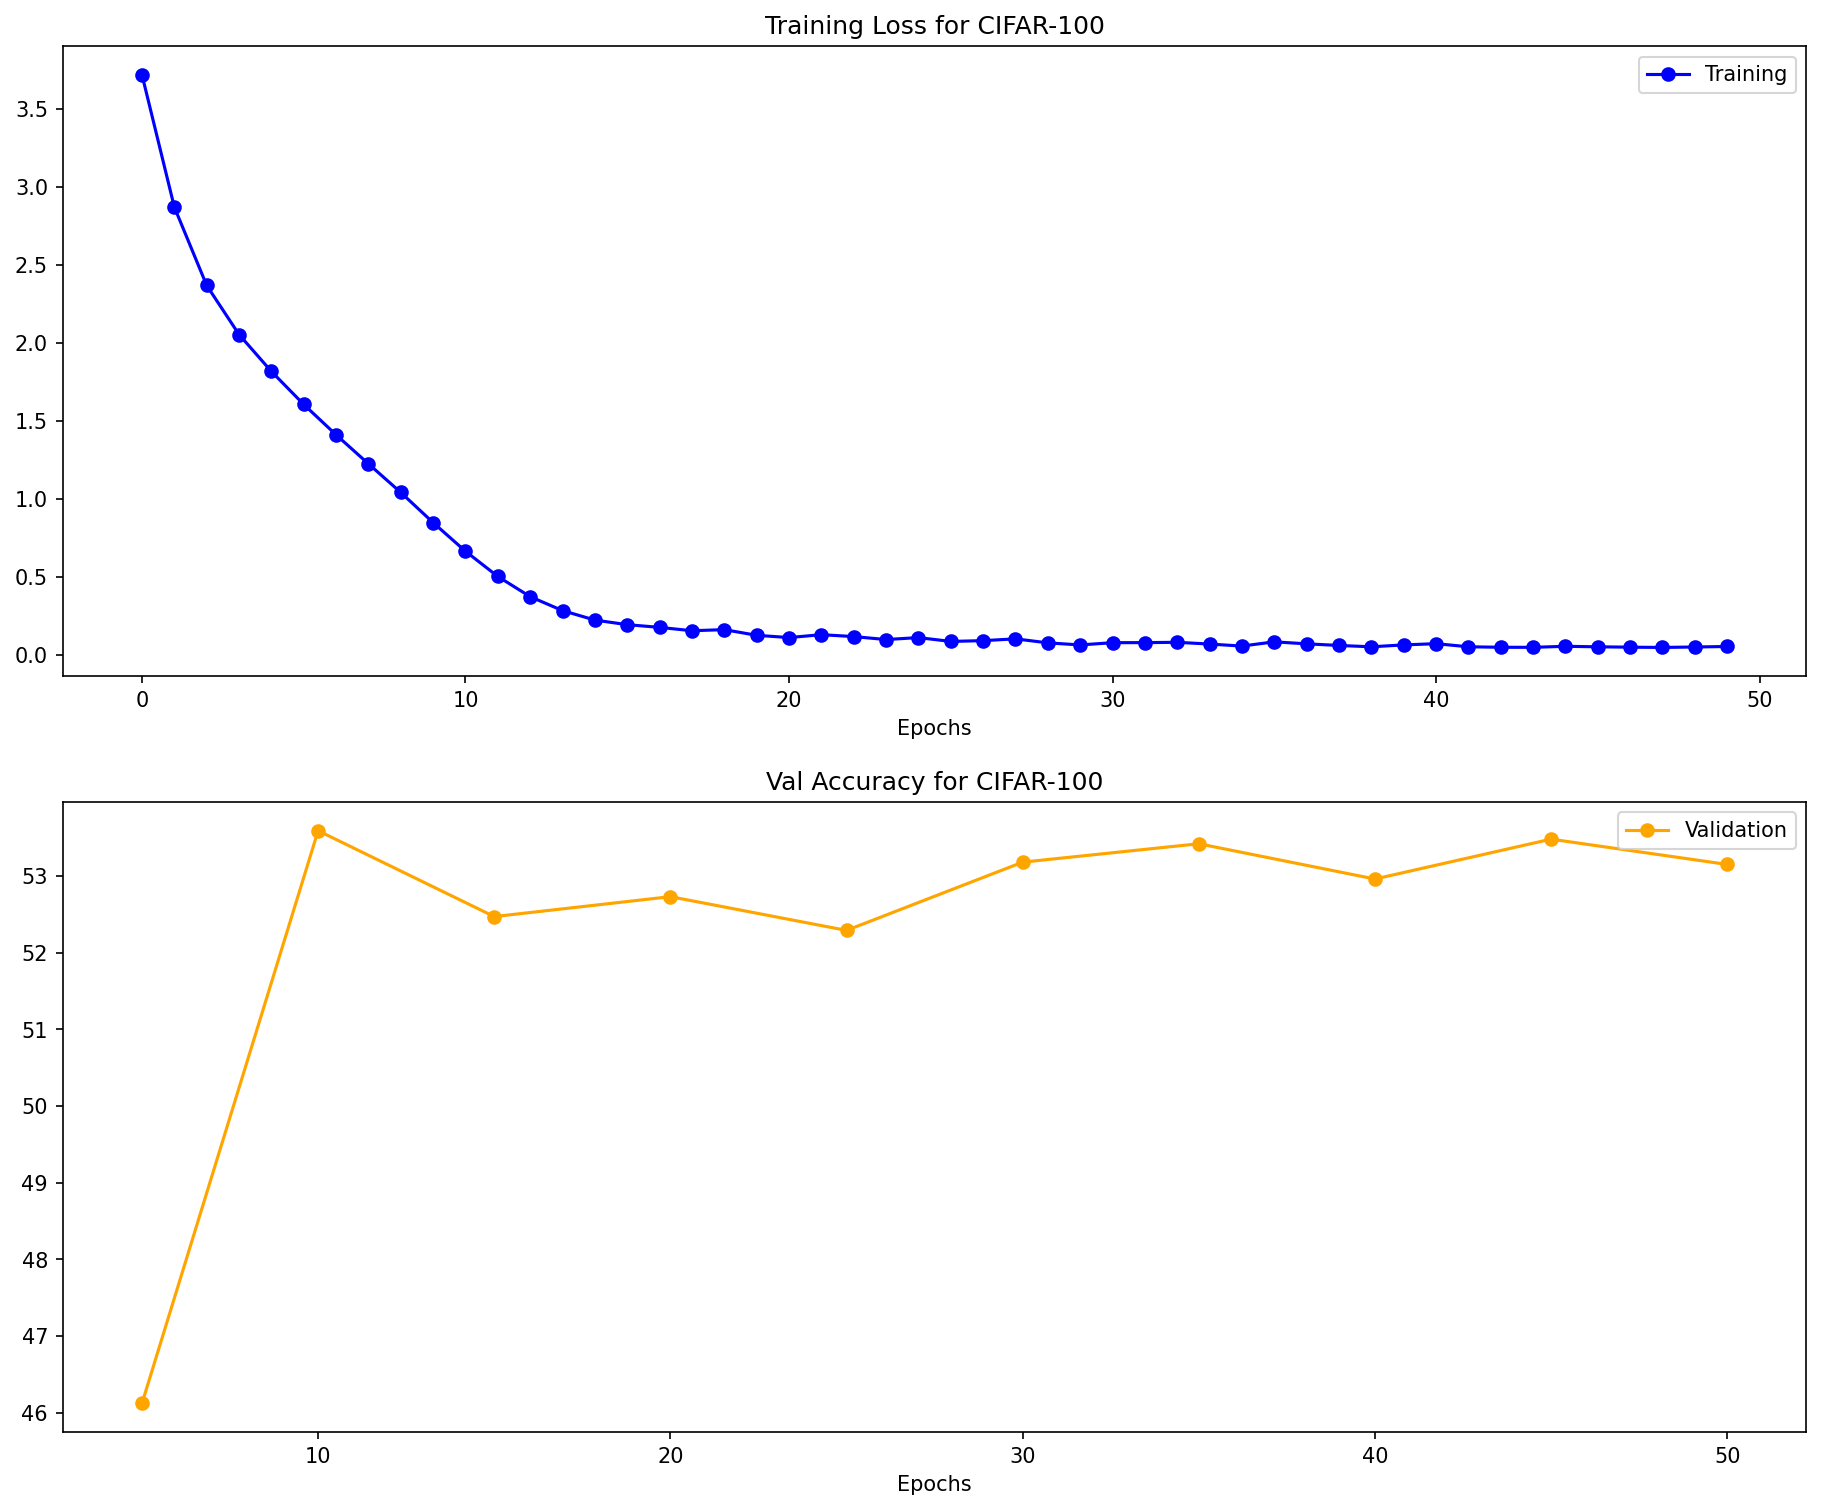

In [14]:
# draw train loss / val acc curve
plt.figure(figsize=(15, 12), dpi=150)
plt.subplot(2, 1, 1)
plt.title('Training Loss for CIFAR-100')
plt.plot(Train_loss_cifar100, '-o', label='Training', color='blue')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
epochs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
plt.title('Val Accuracy for CIFAR-100')
plt.plot(epochs, Val_acc_cifar100, '-o', label='Validation', color='orange')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(15, 12)

plt.show()

**Training Curve:** In the training loss curve for the ResNet18 model trained on the CIFAR-10 and CIFAR-100 dataset, there is a notable trend of decreasing loss as the number of epochs increases. This indicates that the ResNet is learning and improving its predictions on the training set over time. Initially, there is a sharp decline in loss, which then gradually plateaus, suggesting the model is starting to converge and that there are diminishing returns from further training on the training set.

**Validation Curve:** The validation accuracy graph of CIFAR-10 and CIFAR-100 shows a steady increase in accuracy as the number of epochs goes up, which signifies that the model's generalization to unseen data is improving. However, the increase in validation accuracy for both begins to level off towards the end of the graph, indicating that the model might be approaching its peak performance on the validation set. Besides, The validation accuracy for CIFAR-100 is relatively low, since the task is more complicated than CIFAR-10.

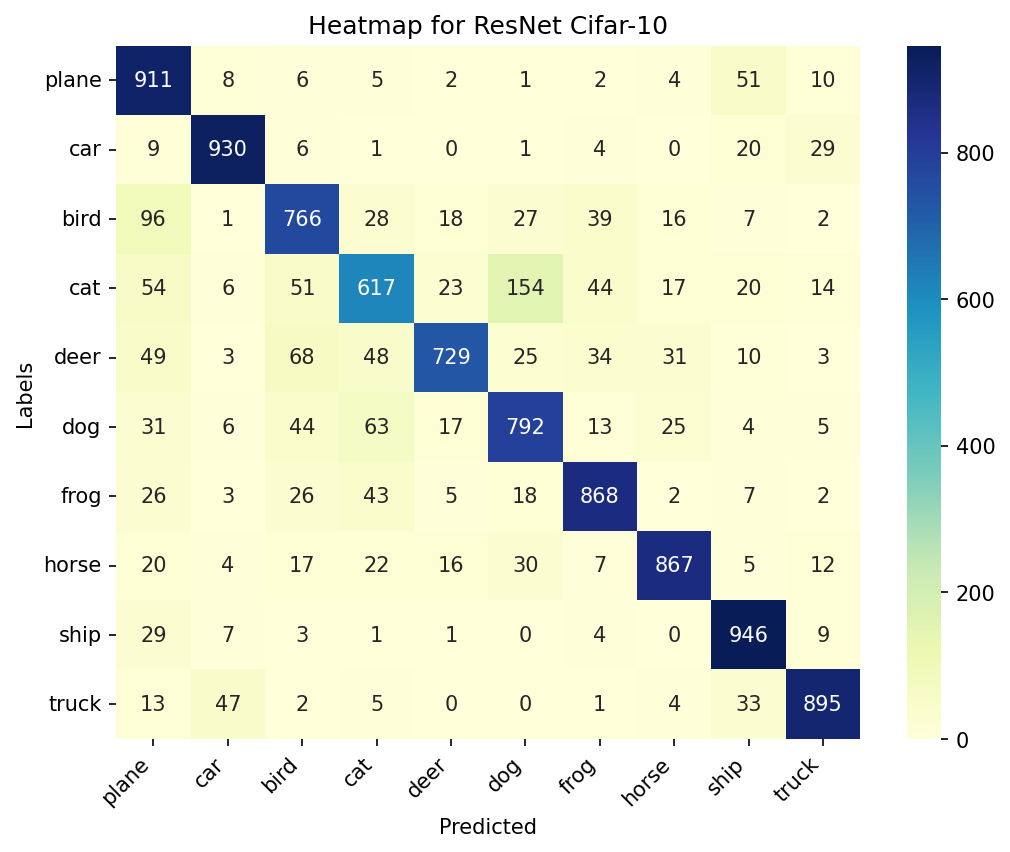

In [16]:
# draw heatmap
label_names = cifar10_dataset.classes
# sns.set_context('talk', font_scale=0.5)
df_cm = pd.DataFrame(conf_matrix_10, index = label_names, columns = label_names)
plt.figure(figsize=(8, 6), dpi=150)
# generate heatmap
heatmap = sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right')
plt.ylabel('Labels')
plt.xlabel('Predicted')
plt.title('Heatmap for ResNet Cifar-10')
plt.show()

**Heatmap:** This heatmap visualization shows a confusion matrix for a ResNet18 model trained on the CIFAR-10 dataset. The diagonal cells represent the number of correct classifications for each class, where we can see high values, indicating good performance on the majority of classes. However, some off-diagonal cells have notably higher values, indicating misclassifications. For CIFAR-100 dataset, since it have 100 classes, it's not suitable to draw the heatmap and visulize (axis will be too tight).

From the matrix, it is clear that certain classes are more challenging for the model to distinguish. For instance, the model frequently confuses dogs with cats, as indicated by the high value in the cell intersecting the cat row and dog column. Similarly, cats are often mistaken for dogs and deer. Planes are also frequently misclassified as birds, which might be due to similarities in the background or the shape of the objects in the images.

**Hyper-Parameters:** I have experimented with varying hyperparameters as well. I found that increasing the learning rate (testing 0.01, 0.001, 0.0005) tends to accelerate initial convergence. However, a learning rate of 0.01 did not yield as good evaluation results as 0.001 or 0.0005. Moreover, enlarging the batch size from 128 to 256 can enhanced the training speed. For training epochs, the validation accuracy CIFAR-10 and CIFAR-100 becomes convergence after 20 epochs.

**Training Time and GPU Memeory used:** It takes around 20s to finished 1 epoch on RTX 3090 GPU. The memory used is around 175 MB for CIFAR-10 ResNet, and 440 MB for CIFAR-100 ResNet. I utilized `time` and `torch.cuda.memory_allocated` to calculate time and memory. Some detailed results are shown in the jupyter output place.